Note: most of this code was written as a part of the assignments at the UBC-MDS program.

In [1]:
import numpy as np
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
# Inputs: image, a 3d numpy array of size NxMx3, where the 3rd dimension is for the colour channels.
# Outputs: an array of size NxM containing the energies

# Computes the "energy" of an image, using the Laplacian of each colour channel and summing them up.
# Inputs: image, a 3d numpy array of size NxMx3
# Outputs: the energy image, a 2d numpy array of size NxM
def energy(image): 
    dy = np.array([-1, 0, 1])[:,None,None]
    dx = np.array([-1, 0, 1])[None,:,None]
    energy_img = convolve(image, dx)**2 + convolve(image, dy)**2
    return np.sum(energy_img, axis=2)

# Find the minimum-energy horizontal seam in an image. 
# Inputs: energy, a 2d numpy array containing the energy values. Size NxM.
# Outputs: a seam represented as a 1d array of length M, with all values between 0 and N-1. 
def find_horizontal_seam(energy):
    return find_vertical_seam(energy.T)

# Remove a vertical seam from an image:
# Inputs:  image, a 2d numpy array containing the pixel values. Size NxM.
#          seam, a 1d array (or list) containing the column index of each pixel in the seam. Length N, all values between 0 and M-1.
# Outputs: a new image that is smaller by 1 column. Size N by M-1.
def remove_vertical_seam(image, seam):
    height = image.shape[0]
    linear_inds = np.array(seam)+np.arange(image.shape[0])*image.shape[1]
    new_image = np.zeros((height,image.shape[1]-1,3), dtype="uint8")
    for c in range(3):
        temp = np.delete(image[:,:,c], linear_inds.astype(int)) 
        temp = np.reshape(temp, (height, image.shape[1]-1))
        new_image[:,:,c] = temp
    return new_image    

# Same as remove_vertical_seam above, but for a horizontal seam. The output image is size N-1 by M.
def remove_horizontal_seam(image, seam):
    return np.transpose(remove_vertical_seam(np.transpose(image,(1,0,2)), seam), (1,0,2))

# Resize an NxM image to a desired height and width. 
# Note: this function only makes images smaller. Enlarging an image is not implemented. 
# Inputs: image, a 3d numpy array of size NxMx3
#         desired_width, an integer giving the desired width
#         desired_height, an integer giving the desired height
# Outputs: the resized image, now of size N x desired_width x 3
def seam_carve(image, desired_height, desired_width):
    while image.shape[1] > desired_width:
        seam = find_vertical_seam(energy(image))
        assert len(seam) == image.shape[0], "the length of the seam must equal the height of the image"
        image = remove_vertical_seam(image, seam)
        sys.stdout.write('\rWidth is now %d' % image.shape[1])
    print()
    while image.shape[0] > desired_height:
        seam = find_horizontal_seam(energy(image))
        assert len(seam) == image.shape[1], "the length of the seam must equal the width of the image"
        image = remove_horizontal_seam(image, seam)
        sys.stdout.write('\rHeight is now %d' % image.shape[0])
    print()
    return image


### Recursive implementation

In [3]:
def find_vertical_seam(energy):
    costs = dict()
    for i in range(energy.shape[1]):
        best_seam, best_cost = fvs(energy, [i], 0.0)
        costs[tuple(best_seam)] = best_cost
    return min(costs, key=costs.get) # the best out of the M best seams

def fvs(energy, seam, cost):
    row = len(seam)-1
    col = seam[-1]
    
    # if out of bounds on one of the two sides, return infinite energy
    if col < 0 or col >= energy.shape[1]:
        return seam, np.inf

    cost += energy[row,col]
    
    # regular base case: reached bottom of image
    if len(seam) == energy.shape[0]:
        return seam, cost

    return min((fvs(energy, seam+[col], cost),
                fvs(energy, seam+[col+1],cost),
                fvs(energy, seam+[col-1],cost)),key=lambda x:x[1])
    # above: could make syntax nicer if I was willing to tolerate some more inefficiency
    # by defining an energy function of seam and re-computing energy of the seam each time

(13, 13, 3)
Width is now 12



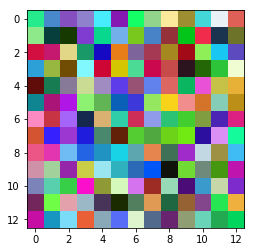

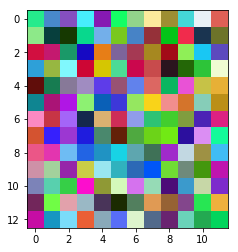

In [4]:
np.random.seed(1)
h = 13
w = 13
img = np.random.randint(0,255,(h,w,3)).astype("uint8")
# img = plt.imread('mandrill.jpg')
print(img.shape)
plt.figure()
plt.imshow(img)
e = energy(img)
# plt.imshow(e)
# print(e)
img2 = seam_carve(img, h, w-1)
plt.figure()
plt.imshow(img2);

### Integer Linear Programming Implementation

In [5]:
import pulp

def find_vertical_seam(energy):
    N, M = energy.shape
    
    # initialize the optimization problem, give it a name
    prob = pulp.LpProblem("Seam carving", pulp.LpMinimize)
    
    # create the x_ij variables
    x = pulp.LpVariable.dicts("pixels",(list(range(N)),list(range(M))),0,1,pulp.LpInteger)
    
    # The objective function is being built here. The objective is the sum of energies in the seam.
    objective_terms = list()
    for i in range(N):
        for j in range(M):
            objective_terms.append(energy[i][j] * x[i][j])
    prob += pulp.lpSum(objective_terms) # adds up all the terms in the list
    
    # Constraint #1: one pixel per row
    for i in range(N):
        prob += pulp.lpSum(x[i][j] for j in range(M)) == 1
        
    # Constraint #2: connectivity of seam
    for i in range(N-1):
        for j in range(M): # below: this says: x(i,j) - x(i+1,j-1) - x(i+1,j) - x(i+1,j+1) <= 0
            prob += pulp.lpSum([x[i][j]]+[-x[i+1][k] for k in range(max(0,j-1),min(M,j+2))]) <= 0
    
    # Solve the problem
    prob.solve()
    
    # Build up the seam by collecting the pixels in the optimal seam
    # Note: you can access the values (0 or 1) of the variables with pulp.value(x[i][j])
    
    seam = []
    for i in range(N):
        for j in range(M):
            if pulp.value(x[i][j]) == 1.0:
                seam.append(j)        
    return seam

(31, 31, 3)
Width is now 30

Width is now 30

Width is now 30

Width is now 30

Width is now 30

Width is now 30

Width is now 30

Width is now 30

Width is now 30

9.75 s ± 721 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


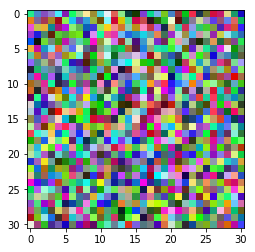

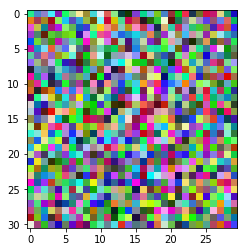

In [6]:
np.random.seed(1)
h = 31
w = 31
img = np.random.randint(0,255,(h,w,3)).astype("uint8")
# img = plt.imread('mandrill.jpg')
print(img.shape)
plt.figure()
plt.imshow(img)
e = energy(img)
# plt.imshow(e)
# print(e)
img3 = seam_carve(img, h, w-1)
%timeit seam_carve(img, h, w-1)
plt.figure()
plt.imshow(img3);

### Dynamic Programming Implementation

In [7]:
def find_vertical_seam(energy):
    """
    Function to get the vertical seam in a picture

    The function takes an energy array for a picture and
    finds the vertical seam with the minimum energy path
    from the top to the bottom of the image.

    Parameters
    ----------
    energy : 2-d array
        The array values for the energy of a picture 
        (each pixel)

    Returns
    -------
    list
        A list containing the indices of the minimum energy
        path from the top to the bottom of an image, i.e, the 
        vertical seam for the image.
    """
    row = energy.shape[0]
    col = energy.shape[1]
    dp_energy = []
    dp_energy.append(energy[0].tolist())
        
    for i in range(1, row):
        temp = []
        for j in range(col):
            if j == 0:
                temp.append(energy[i][j] + min(dp_energy[i-1][j], dp_energy[i-1][j+1]))
            elif j == col - 1:
                temp.append(energy[i][j] + min(dp_energy[i-1][j], dp_energy[i-1][j-1]))
            else:
                temp.append(energy[i][j] + min(dp_energy[i-1][j-1], dp_energy[i-1][j], dp_energy[i-1][j+1]))
        dp_energy.append(temp)
    
    # backtracking to get the seam
    seam = [0] * row
    seam[row-1] = np.argmin(dp_energy[row-1])
    for i in range(row-2, -1, -1):
        j = seam[i+1]
        if j == 0:
            seam[i] = np.argmin(dp_energy[i][j:j+2]) + j
        elif j == col - 1:
            seam[i] = np.argmin(dp_energy[i][j-1:j+1]) + j-1
        else:
            seam[i] = np.argmin(dp_energy[i][j-1:j+2]) + j-1
    return seam

(13, 13, 3)
Width is now 12



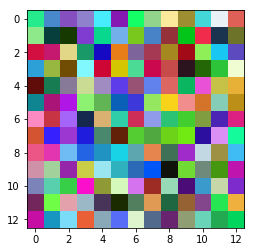

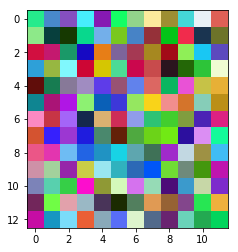

In [8]:
np.random.seed(1)
h = 13
w = 13
img = np.random.randint(0,255,(h,w,3)).astype("uint8")
# img = plt.imread('mandrill.jpg')
print(img.shape)
plt.figure()
plt.imshow(img)
e = energy(img)
# plt.imshow(e)
# print(e)
img2 = seam_carve(img, h, w-1)
plt.figure()
plt.imshow(img2);

The big-O running time for the iterative `find_vertical_seam` is $O(M*N)$ since we just loop over the rows and columns of a 2-d array same as the size of the energy matrix.

(298, 298, 3)
Width is now 149
Height is now 149


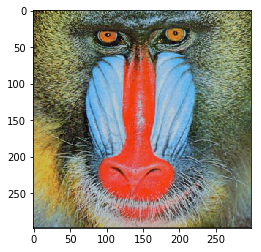

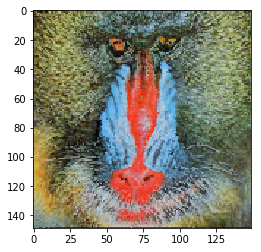

In [9]:
np.random.seed(1)
img = plt.imread('imgs/mandrill.jpg')
print(img.shape)
h = img.shape[0]//2
w = img.shape[1]//2
plt.figure()
plt.imshow(img)
e = energy(img)
# plt.imshow(e)
# print(e)
img2 = seam_carve(img, h, w)
plt.figure()
plt.imshow(img2);

#![](mandrill.jpg)

(3888, 2592, 3)
Width is now 2582
Height is now 3878


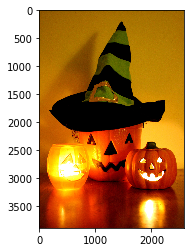

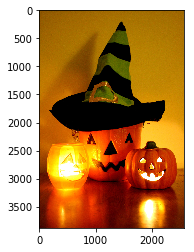

In [10]:
np.random.seed(1)
img = plt.imread('imgs/halloween-jack-o-lantern-bucket-with-witch-hat-and-candles.jpg')
print(img.shape)
h = img.shape[0] - 10
w = img.shape[1] - 10
plt.figure()
plt.imshow(img)
e = energy(img)
# plt.imshow(e)
# print(e)
img2 = seam_carve(img, h, w)
plt.figure()
plt.imshow(img2);

#![](halloween-jack-o-lantern-bucket-with-witch-hat-and-candles.jpg)

Comparing DP implementation with linear programming, we will find the time for random image with width = 31 for the DP implementation:

In [11]:
# run this code to compare DP with ILP
# np.random.seed(1)
# h = 31
# w = 31
# img = np.random.randint(0,255,(h,w,3)).astype("uint8")
# # img = plt.imread('mandrill.jpg')
# print(img.shape)
# plt.figure()
# plt.imshow(img)
# e = energy(img)
# # plt.imshow(e)
# # print(e)
# img2 = seam_carve(img, h, w-1)
# %timeit seam_carve(img, h, w-1)
# plt.figure()
# plt.imshow(img2);

> If you run the above code, you will see that the time taken by DP implementation is around `3.98 ms` as compared to the `9.14 s` taken by the integer linear programming approach which is more than 2000 times faster! Dynamic programming is beautiful!